In [1]:
%load_ext autoreload
%autoreload 2

Loading frames 1 to 101


frame:   0%|          | 0/100 [00:00<?, ?it/s]

Frameset: wr_210522_64_center, 100 frames with 9 channels JIT enabled
Loading frames 1 to 101


frame:   0%|          | 0/100 [00:00<?, ?it/s]

Frameset: wr_210522_256_center, 100 frames with 9 channels JIT enabled
Frameset: wr_210522_low_res_rgb, 100 frames with 1 channels JIT enabled
Frameset: wr_210522_high_res_rgb, 100 frames with 1 channels JIT enabled
(80, 64, 64, 3)
(80, 64, 64, 3)
(80, 256, 256, 3)
(20, 256, 256, 3)
(256, 256, 3)


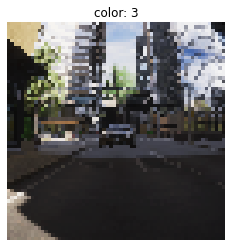

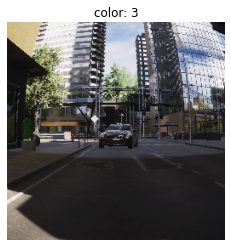

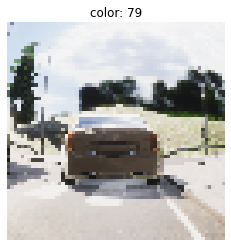

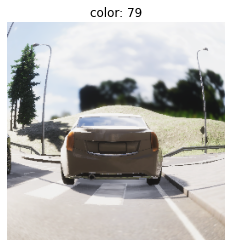

In [1]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

#frameset_res_low = 64

g_fVerbose = False
g_fJITLoading = True
frameset_res_low = 64
frameset_res_high = 256
res_factor = frameset_res_high // frameset_res_low
strFramesetBaseName = 'wr_210522'
strFramesetSensorName = 'center'
strFramesetName_low = strFramesetBaseName + '_' + str(frameset_res_low) + '_' + strFramesetSensorName
strFramesetName_high = strFramesetBaseName + '_' + str(frameset_res_high) + '_' + strFramesetSensorName
img_size = 32
batch_size = 128
test_batch_size = 128
num_frames = None
#num_frames = 4900
num_frames = 100


frameset_low_res = frameset(strFramesetName_low, num_frames=num_frames, fJITLoading=g_fJITLoading, fVerbose=g_fVerbose)
frameset_low_res.Print()

frameset_high_res = frameset(strFramesetName_high, num_frames=num_frames, fJITLoading=g_fJITLoading, fVerbose=g_fVerbose)
frameset_high_res.Print()

# Split up into RGB and respective target framesets
frameset_low_res_rgb = frameset(
    sourceFrameset=frameset_low_res, 
    strNewFramesetName=strFramesetBaseName + "_low_res_rgb", 
    sourceChannels=[
        'Color',
    ]
)

frameset_high_res_rgb = frameset(
    sourceFrameset=frameset_high_res, 
    strNewFramesetName=strFramesetBaseName + "_high_res_rgb", 
    sourceChannels=['Color']
)

frameset_low_res_rgb.Print()
#frameset_low_res_rgb[0].visualize()

frameset_high_res_rgb.Print()
#frameset_high_res_rgb[0].visualize()

# split into train and test

frameset_low_res_rgb_train, frameset_low_res_rgb_test = frameset_low_res_rgb.split_into_train_and_test(0.8)
print(frameset_low_res_rgb_train.shape())
print(frameset_low_res_rgb_train.shape())
train_idx = frameset_low_res_rgb_train.get_frame_ids()
test_idx = frameset_low_res_rgb_test.get_frame_ids()

frameset_high_res_rgb_train, frameset_high_res_rgb_test = frameset_high_res_rgb.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(frameset_high_res_rgb_train.shape())
print(frameset_high_res_rgb_test.shape())

# Confirm the match-up
frameset_low_res_rgb_train[3].visualize()
frameset_high_res_rgb_train[3].visualize()
print(frameset_high_res_rgb_train[0].GetNumpyBuffer().shape)

frameset_low_res_rgb_test[1].visualize()
frameset_high_res_rgb_test[1].visualize()

In [4]:
import torch

from repos.pyjunk.models.GAN.SRGAN import SRGAN
from repos.pyjunk.solvers.SRGANTorchSolver import SRGANTorchSolver

import repos.pyjunk.junktools.pytorch_utils as ptu
#ptu.SetGPUMode(True)

import repos.pyjunk.junktools.pytorch_utils as ptu
#ptu.SetGPUMode(True)

# TODO: Add the depth channel to input bruv

# Set up model
num_low_rgb, H_low_rgb, W_low_rgb, C_low_rgb = frameset_low_res_rgb_train.shape()
num_high_rgb, H_high_rgb, W_high_rgb, C_high_rgb = frameset_high_res_rgb_train.shape()

batch_size = 16
test_batch_size = 5

print("input dims: %d, %d, %d" % (H_low_rgb, W_low_rgb, C_low_rgb))
print("target dims: %d, %d, %d" % (H_high_rgb, W_high_rgb, C_high_rgb))

ganModel = SRGAN(
    input_shape=(H_low_rgb, W_low_rgb, C_low_rgb),
    output_shape=(H_high_rgb, W_high_rgb, C_high_rgb)
)

strCheckpointName = 'srgan_checkpoint'

# Set up the solver
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 1e5,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'n_critic': 1,
    #'betas': (0.0, 0.9),
    'checkpoint_file_name': strCheckpointName + '.tar',
    'checkpoint_epochs': 10,
    'save_test_file_name': strCheckpointName + '.png',
}

# test gen, disc
# npFrameBuffer = frameset_low_res_rgb_train[1].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0).to(ptu.GetDevice())
# print(torchImageBuffer.shape)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# out_fake = ganModel.generator.forward(torchImageBuffer)
# print(out_fake.shape)

# # print(test_data.shape)
# pred_fake = ganModel.discriminator(out_fake)
# print(pred_fake.shape)

solver = SRGANTorchSolver(ganModel, dictSolverParams)
solver.train_res_epochs_frameset(
    frameset_low_res_rgb_train, frameset_high_res_rgb_train, 
    fVerbose=False)

# solver.train_gan_epochs_frameset(
#     frameset_low_res_rgb_train, frameset_high_res_rgb_train, 
#     fVerbose=False)

input dims: 64, 64, 3
target dims: 256, 256, 3


Epoch:   0%|          | 0/100000 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/16 [00:00<?, ?it/s]

Saving checkpoint to srgan_checkpoint.tar at epoch 10 and loss 0.12009742110967636


AttributeError: 'Tensor' object has no attribute 'SaveToFile'

In [59]:
import torch

strCheckpoint = strCheckpointName + '.tar'

solver.SaveCheckpoint(strCheckpoint, 1)

In [ ]:
import torch

strCheckpoint = strCheckpointName + '.tar'

solver.LoadCheckpoint(strCheckpoint)
solver.train_gan_epochs_frameset(frameset_low_res_rgb_train, frameset_high_res_rgb_train, fVerbose=False)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/128 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


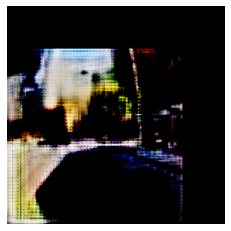

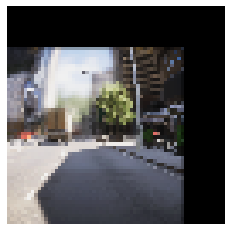

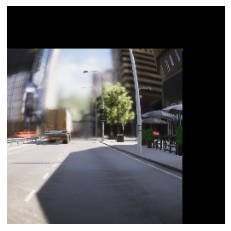

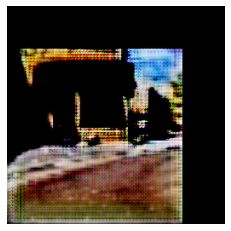

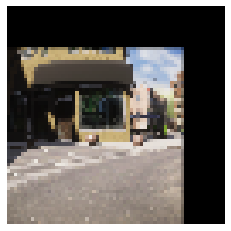

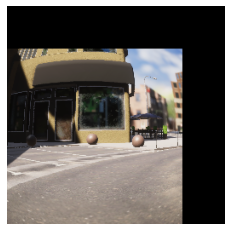

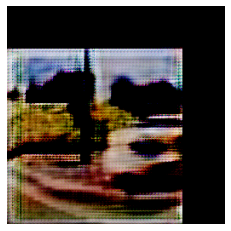

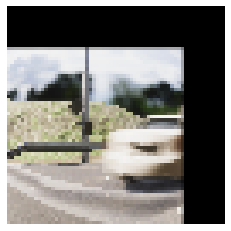

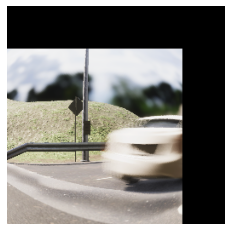

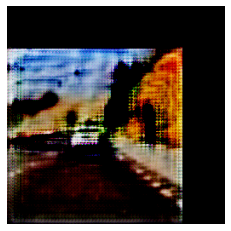

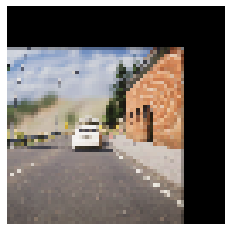

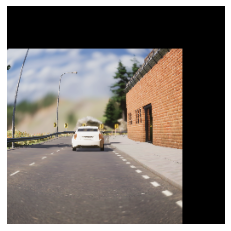

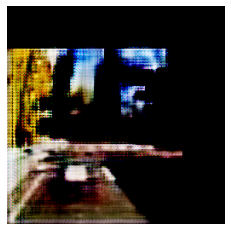

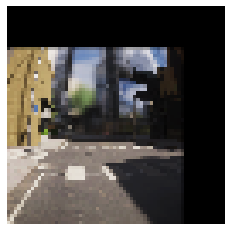

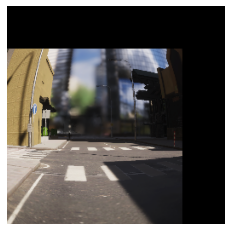

In [14]:
# from repos.pyjunk.junktools.image import image
# from repos.pyjunk.junktools import utils
# import numpy as np

# n_row = 4
# samples = ganModel.sample(n_row ** 2).cpu().numpy()
# utils.visualize_data(samples, size=n_row ** 2, nrow=n_row,)
# # for sample in samples:
# #     newImage = image(tor  
# #     newImage.visualize()

# # #print(list(ganModel.generator.parameters()))
# # print(list(ganModel.discriminator.parameters()))


import random
n_frames = 5

for n in range(n_frames):
    frameid = random.randint(0, frameset_low_res_rgb_test.num_frames - 1)

    # test the forward pass
    fwdPassImg = ganModel.forward_with_frame(frameset_low_res_rgb_test[frameid])
    fwdPassImg.visualize()
    frameset_low_res_rgb_test[frameid]['color'].visualize()
    frameset_high_res_rgb_test[frameid]['color'].visualize()